In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm

In [98]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    client = Client(cluster)
    return cluster, client

In [99]:
cluster, client = get_ClusterClient()
cluster.scale(20)

/glade/work/djk2120/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36995 instead
  http_address["port"], self.http_server.port


In [100]:
client

Client Scheduler: tcp://10.12.206.63:36323 Dashboard: https://https://jupyterhub.hpc.ucar.edu/stable/user/djk2120/proxy/{port}/status,Cluster Workers: 20 Cores: 20 Memory: 500.00 GB


### inspect the streamfiles

In [6]:
dir1 = '/glade/p/cgd/tss/CTSM_datm_forcing_data/atm_forcing.datm7.CRUJRA.0.5d.v1.c190604/'
dir2 = '/glade/scratch/djk2120/ctsm_trendy_2021/forcing/three_stream/'

In [21]:
f = 'clmforc.CRUJRAV1.1.c2019.0.5x0.5.TPQWL.2000-01.nc'
ds0 = xr.open_dataset(dir1+f)
t0 = ds0.TBOT.mean(dim='time')

In [38]:
f = 'clmforc.TRENDY.c2021_0.5x0.5.TPQWL.2000.nc'
ds = xr.open_dataset(dir2+f)
ixt = ds['time.month']==1
t = ds.TBOT.isel(time=ixt).mean(dim='time')

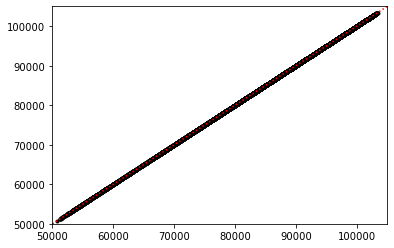

In [40]:
p0 = ds0.PSRF.mean(dim='time')
p  = ds.PSRF.isel(time=ixt).mean(dim='time')
plt.plot(p,p0,'k.')
plt.xlim([50000,105000])
plt.ylim([50000,105000])
plt.plot([50000,105000],[50000,105000],'r:');

In [52]:
ds

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 1460)
Coordinates:
  * time     (time) object 2000-01-01 03:00:00 ... 2000-12-31 21:00:00
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Data variables:
    LONGXY   (lat, lon) float32 ...
    LATIXY   (lat, lon) float32 ...
    TBOT     (time, lat, lon) float32 ...
    PSRF     (time, lat, lon) float32 ...
    QBOT     (time, lat, lon) float32 ...
    WIND     (time, lat, lon) float32 ...
    FLDS     (time, lat, lon) float32 ...
Attributes:
    creation_date:   
    conventions:     
    case_title:     TRENDY 6-Hourly Atmospheric Forcing: Temperature, Pressur...

In [69]:
ds1

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 124)
Coordinates:
  * time     (time) object 2000-07-01 03:00:00 ... 2000-07-31 21:00:00
Dimensions without coordinates: lat, lon
Data variables:
    LONGXY   (lat, lon) float32 ...
    LATIXY   (lat, lon) float32 ...
    TBOT     (time, lat, lon) float32 ...
    PSRF     (time, lat, lon) float32 ...
    QBOT     (time, lat, lon) float32 ...
    WIND     (time, lat, lon) float32 ...
    FLDS     (time, lat, lon) float32 ...
Attributes:
    creation_date:   
    conventions:     
    case_title:     CRUJRA V1.1 6-Hourly Atmospheric Forcing: Temperature, Pr...

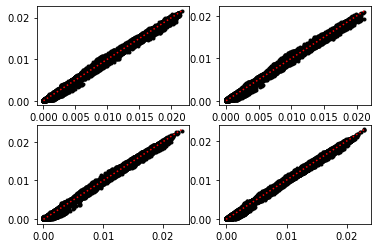

In [75]:
month = 1
year = 1901
day = 1


f1 = 'clmforc.CRUJRAV1.1.c2019.0.5x0.5.TPQWL.'+str(year)+'-'+str(month).zfill(2)+'.nc'
f2 = 'clmforc.TRENDY.c2021_0.5x0.5.TPQWL.'+str(year)+'.nc'
ds1 = xr.open_dataset(dir1+f1)
ds2 = xr.open_dataset(dir2+f2)

ixt1 = ds1['time.day']==day
ixt2 = np.logical_and(ds2['time.month']==month,ds2['time.day']==day)

thisvar = 'QBOT'
x1  = ds1[thisvar].isel(time=ixt1)
x2  = ds2[thisvar].isel(time=ixt2)
for i in range(4):
    x11 = x1.isel(time=i)
    x22 = x2.isel(time=i)
    xmin = x11.min()
    xmax = x11.max()
    ix = x22>0
    plt.subplot(2,2,i+1)
    plt.plot(x11.where(ix),x22.where(ix),'k.')
    plt.plot([xmin,xmax],[xmin,xmax],'r:')


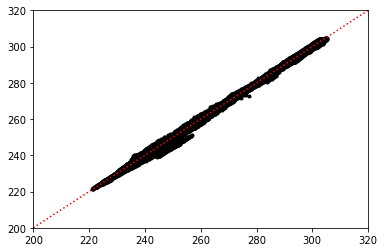

In [26]:
plt.plot(t0,t,'k.')
plt.plot([200,320],[200,320],'r:')
plt.xlim([200,320])
plt.ylim([200,320]);

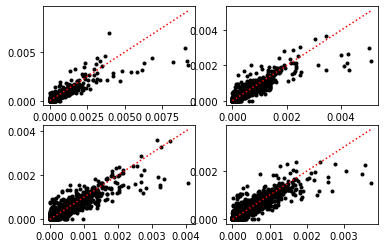

In [82]:
month = 7
year = 1981
day = 1

f1 = 'clmforc.CRUJRAV1.1.c2019.0.5x0.5.Prec.'+str(year)+'-'+str(month).zfill(2)+'.nc'
f2 = 'clmforc.TRENDY.c2021_0.5x0.5.Prec.'+str(year)+'.nc'
ds1 = xr.open_dataset(dir1+f1)
ds2 = xr.open_dataset(dir2+f2)

ixt1 = ds1['time.day']==day
ixt2 = np.logical_and(ds2['time.month']==month,ds2['time.day']==day)

thisvar = 'PRECTmms'
x1  = ds1[thisvar].isel(time=ixt1)
x2  = ds2[thisvar].isel(time=ixt2)
for i in range(4):
    x11 = x1.isel(time=i)
    x22 = x2.isel(time=i)
    xmin = x11.min()
    xmax = x11.max()
    ix = x22>0
    plt.subplot(2,2,i+1)
    plt.plot(x11.where(ix),x22.where(ix),'k.')
    plt.plot([xmin,xmax],[xmin,xmax],'r:')

In [83]:
month = 7
year = 1981
day = 1

f1 = 'clmforc.CRUJRAV1.1.c2019.0.5x0.5.Solr.'+str(year)+'-'+str(month).zfill(2)+'.nc'
f2 = 'clmforc.TRENDY.c2021_0.5x0.5.Solr.'+str(year)+'.nc'
ds1 = xr.open_dataset(dir1+f1)
ds2 = xr.open_dataset(dir2+f2)

ixt1 = ds1['time.day']==day
ixt2 = np.logical_and(ds2['time.month']==month,ds2['time.day']==day)

In [ ]:
var1 = 'FSDS'
var2 = 'FSDS_DIRECT'
var3 = 'FSDS_DIFFUSE'
x1  = ds1[var1].isel(time=ixt1)
x2  = (ds2[var2]+ds2[var3]).isel(time=ixt2)
for i in range(4):
    x11 = x1.isel(time=i)
    x22 = x2.isel(time=i)
    xmin = x11.min()
    xmax = x11.max()
    ix = x22>0
    plt.subplot(2,2,i+1)
    plt.plot(x11.where(ix),x22.where(ix),'k.')
    plt.plot([xmin,xmax],[xmin,xmax],'r:')

### check that the masks align

In [2]:
ds0 = xr.open_dataset('/glade/scratch/djk2120/ctsm_trendy_2021/forcing/three_stream/domain.crujra_v2.2_0.5x0.5.c210804.nc')


In [4]:
ds1 = xr.open_dataset('/glade/scratch/djk2120/ctsm_trendy_2021/forcing/met/crujra.v2.2.5d.pres.2020.365d.noc.nc')

In [5]:
ds2 = xr.open_dataset('/glade/scratch/djk2120/ctsm_trendy_2021/forcing/met/tswrf_v10_2020.nc')

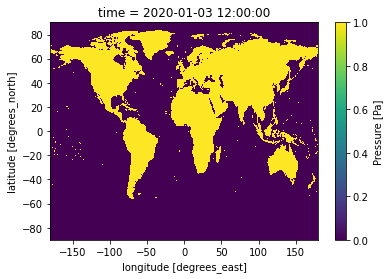

In [21]:
(~np.isnan(ds1.pres.isel(time=10))).plot()

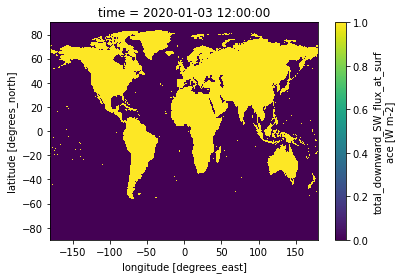

In [31]:
x=(~np.isnan(ds2.tswrf.isel(time=10)))
x.plot()

In [33]:
x[:,:360]

<xarray.DataArray 'tswrf' (lat: 360, lon: 360)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... -1.25 -0.75 -0.25
    time     object 2020-01-03 12:00:00
Attributes:
    cell_methods:   time: mean
    long_name:      total_downward_SW_flux_at_surface
    standard_name:  total_downward_SW_flux_at_surface
    units:          W m-2

In [34]:
y=ds0.mask

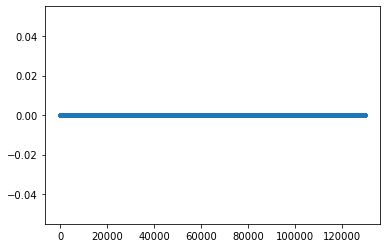

In [37]:
x2=x[:,:360].values.ravel()
y2=y[:,360:].values.ravel()
plt.plot(x2-y2,'.')

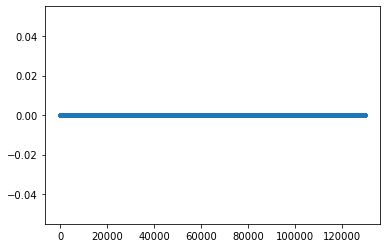

In [39]:
x2=x[:,360:].values.ravel()
y2=y[:,:360].values.ravel()
plt.plot(x2-y2,'.')

In [44]:
d = '/glade/scratch/djk2120/ctsm_trendy_2021/forcing/ndep/'
f = 'drynhx_input4MIPs_surfaceFluxes_CMIP_hist_ssp585_NCAR-CCMI-2-0_gn_185001-209912.720x360.nc'
ds = xr.open_dataset(d+f,decode_times=False)

In [47]:
f = '/glade/p/cgd/tss/people/dll/TRENDY2019_Forcing/Ndep/TRENDY2019_Ndep_Monthly_c190821.nc'
ds2 = xr.open_dataset(f)

In [50]:
ds2

<xarray.Dataset>
Dimensions:                  (lat: 192, lon: 288, nbnd: 2, time: 3000)
Coordinates:
  * lat                      (lat) float64 -90.0 -89.06 -88.12 ... 89.06 90.0
  * lon                      (lon) float64 0.0 1.25 2.5 ... 356.2 357.5 358.8
  * time                     (time) object 1850-01-16 12:00:00 ... 2099-12-16...
Dimensions without coordinates: nbnd
Data variables:
    gw                       (lat) float64 3.382e-05 0.0002705 ... 3.382e-05
    date                     (time) float64 1.85e+07 1.85e+07 ... 2.099e+07
    time_bnds                (time, nbnd) object 1850-01-01 00:00:00 ... 2100...
    dry_deposition_NHx_as_N  (time, lat, lon) float32 ...
    dry_deposition_NOy_as_N  (time, lat, lon) float32 ...
    wet_deposition_NHx_as_N  (time, lat, lon) float32 ...
    wet_deposition_NOy_as_N  (time, lat, lon) float32 ...
    datesec                  (time) int32 0 0 0 ... -2147483647 -2147483647
    NDEP_NOy_month           (time, lat, lon) float32 ...
    NDEP_NHx_month           (time, lat, lon) float32 ...
    NDEP_month               (time, lat, lon) float32 ...
Attributes:
    Conventions:               CF-1.0
    source:                    CAM
    case:                      b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.00...
    logname:                   cmip6
    host:                      cheyenne1
    initial_file:              b.e21.BW1850.f09_g17.CMIP6-piControl.001.cam.i...
    topography_file:           /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/...
    model_doi_url:             https://doi.org/10.5065/D67H1H0V
    time_period_freq:          month_1
    history:                   
    NCO:                       netCDF Operators version 4.7.4 (http://nco.sf....
    nco_openmp_thread_number:  1
    source_data:               \nEnsemble mean of linearly interpolated 5 yea...
    creation_date:             \nWed Sep 26 12:11:25 MDT 2018
    cesm_contact:              \nKeith Oleson, NCAR CGD, oleson@ucar.edu
    data_script:               \nConverted from data_source_files by program ...
    comment:                   1849 and 1850 data are from 1850 WACCM simulat...

### edit the ndep files

In [68]:
f = glob.glob('/glade/scratch/djk2120/ctsm_trendy_2021/forcing/ndep/*.nc')
ds2 = xr.open_mfdataset(f,combine='nested',decode_times=False)

['/glade/scratch/djk2120/ctsm_trendy_2021/forcing/ndep/drynoy_input4MIPs_surfaceFluxes_CMIP_hist_ssp585_NCAR-CCMI-2-0_gn_185001-209912.720x360.nc',
 '/glade/scratch/djk2120/ctsm_trendy_2021/forcing/ndep/wetnhx_input4MIPs_surfaceFluxes_CMIP_hist_ssp585_NCAR-CCMI-2-0_gn_185001-209912.720x360.nc',
 '/glade/scratch/djk2120/ctsm_trendy_2021/forcing/ndep/drynhx_input4MIPs_surfaceFluxes_CMIP_hist_ssp585_NCAR-CCMI-2-0_gn_185001-209912.720x360.nc',
 '/glade/scratch/djk2120/ctsm_trendy_2021/forcing/ndep/wetnoy_input4MIPs_surfaceFluxes_CMIP_hist_ssp585_NCAR-CCMI-2-0_gn_185001-209912.720x360.nc']

In [52]:
f = '/glade/p/cgd/tss/people/dll/TRENDY2019_Forcing/Ndep/TRENDY2019_Ndep_Monthly_c190821.nc'
ds = xr.open_dataset(f)

In [73]:
ndep = xr.Dataset()
clm_names = ['dry_deposition_NHx_as_N','dry_deposition_NOy_as_N','wet_deposition_NHx_as_N','wet_deposition_NOy_as_N']
trn_names = ['drynhx','drynoy','wetnhx','wetnoy']

for clm,trn in zip(clm_names,trn_names):
    ndep[clm]=ds2[trn].copy(deep=True)
    

In [90]:
noy = 'NDEP_NOy_month'
ndep[noy] = 1000*(ds2.drynoy+ds2.wetnoy).copy(deep=True)
ndep[noy].attrs = ds[noy].attrs

nhx = 'NDEP_NHx_month'
ndep[nhx] = 1000*(ds2.drynhx+ds2.wetnhx).copy(deep=True)
ndep[nhx].attrs = ds[nhx].attrs

ntot = 'NDEP_month'
ndep[ntot] = ndep[noy]+ndep[nhx]
ndep[ntot].attrs = ds[ntot].attrs

ndep['time']=ds['time'].copy(deep=True)

In [114]:
thedir = '/glade/scratch/djk2120/ctsm_trendy_2021/forcing/ndep/'
nfile  = thedir+'TRENDY2021_Ndep_Monthly_c210817.nc'
ndep['dry_deposition_NHx_as_N'].to_netcdf(nfile)

In [127]:
appends = list(ndep.data_vars)
appends.remove('dry_deposition_NHx_as_N')
appends

['dry_deposition_NOy_as_N',
 'wet_deposition_NHx_as_N',
 'wet_deposition_NOy_as_N',
 'NDEP_NOy_month',
 'NDEP_NHx_month',
 'NDEP_month']

In [128]:
for thisvar in appends:
    print(thisvar)
    ndep[thisvar].to_netcdf(nfile,'a')

dry_deposition_NOy_as_N
wet_deposition_NHx_as_N
wet_deposition_NOy_as_N
NDEP_NOy_month
NDEP_NHx_month
NDEP_month


In [144]:
da = ds.datesec.copy(deep=True)
da[:]=0
ndep['datesec'] = da.copy(deep=True)

In [145]:
ndep['date']=ds['date'].copy(deep=True)

In [149]:
gw = np.cos(ndep.lat/360*2*np.pi)
gw = 2*gw/gw.sum()
ndep['gw'] = xr.DataArray(gw,dims='lat')

In [162]:
appends = ['date','datesec','gw']
for thisvar in appends:
    print(thisvar)
    ndep[thisvar].to_netcdf(nfile,'a')

date
datesec
gw


In [163]:
tmp = xr.open_dataset('/glade/scratch/djk2120/ctsm_trendy_2021/forcing/ndep/tmp3.nc')

In [164]:
tmp

<xarray.Dataset>
Dimensions:                  (lat: 360, lon: 720, time: 3000)
Coordinates:
  * time                     (time) object 1850-01-16 12:00:00 ... 2099-12-16...
  * lon                      (lon) float64 -179.8 -179.2 -178.8 ... 179.2 179.8
  * lat                      (lat) float64 -89.75 -89.25 -88.75 ... 89.25 89.75
Data variables:
    dry_deposition_NHx_as_N  (time, lat, lon) float32 ...
    dry_deposition_NOy_as_N  (time, lat, lon) float32 ...
    wet_deposition_NHx_as_N  (time, lat, lon) float32 ...
    wet_deposition_NOy_as_N  (time, lat, lon) float32 ...
    NDEP_NOy_month           (time, lat, lon) float32 ...
    NDEP_NHx_month           (time, lat, lon) float32 ...
    NDEP_month               (time, lat, lon) float32 ...
    date                     (time) float64 ...
    datesec                  (time) int32 ...
    gw                       (lat) float64 ...

In [177]:
ix = ds['time.year']==2016
ds.datesec[ix]

<xarray.DataArray 'datesec' (time: 12)>
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)
Coordinates:
  * time     (time) object 2016-01-16 12:00:00 ... 2016-12-16 12:00:00
Attributes:
    long_name:  current seconds of current date